# Optimal probabilistic clustering - Part II
> ...

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [Clustering, Entropy, Membership Entropy]
- image: images/post_image_optimal_clustering.png
- hide: false
- search_exclude: false
- author: Joao Rodrigues

In [9]:
######################################## Part I
from fcmeans import FCM

def run_cluster(n_clusters, features, random_state=42):
    # membership probabilities
    model = FCM(n_clusters=n_clusters, random_state=random_state, max_iter=1000, error=1e-9).fit(features)
    p = model.u
    # representative cluster
    representative_cluster = np.argmax(p, 1)
    # membership entropy
    Sx = -np.sum(p*np.log(p), 1) / np.log(n_clusters)
    # total membership entropy (across the entire feature space)
    S = np.sum(Sx)        
    
    return p, representative_cluster, Sx, S



## Experimental results

In [4]:
import numpy as np

(n,k,m) n observations, k clusters, at least m observations per cluster

In [5]:
def construct_random_partition(n, k, m, seed=None):
    rand = np.random.RandomState(seed=seed)
    parts = rand.choice(range(1, n-k*(m-1)), k-1, replace=False)
    parts.sort()
    parts = np.append(parts, n-k*(m-1))
    parts = np.append(parts[0], np.diff(parts)) - 1 + m
    
    return parts

In [76]:
partition = construct_random_partition(n=100, k=5, m=2, seed=40)
print(partition)

[13 26 22 33  6]


**Generation of random datasets**

In [77]:
def generate_random_dataset(partition, n_features, std, seed):
    random_state = np.random.RandomState(seed=seed)
    dataset = list()
    for n in partition:
        # cluster centre coordinates
        cluster_centre = random_state.uniform(-1, 1, n_features)
        # observation coordinates
        for observation in range(0, n):
            dataset.append(cluster_centre+std*random_state.standard_normal(n_features))
    dataset = np.array(dataset)
    # shuffles the observations
    dataset = dataset[random_state.permutation(dataset.shape[0]), :]
    
    return np.array(dataset)

In [78]:
dataset = generate_random_dataset(partition=partition, n_features=2, std=0.05, seed=42)

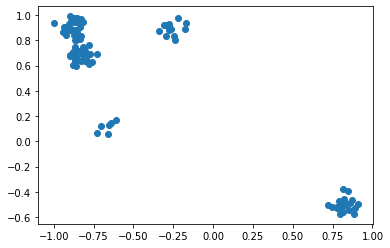

In [79]:
import matplotlib.pyplot as plt
plt.scatter(dataset[:,0], dataset[:,1])
plt.show()

In [92]:
n_clusters_trials = np.arange(2, 15, 1)
total_entropies = list()
for trial in n_clusters_trials:
    _, _, _, total_entropy = run_cluster(n_clusters=trial, features=dataset, random_state=20)
    total_entropies.append(total_entropy)
    

In [93]:
optimal_nclusters = n_clusters_trials[np.argmin(total_entropies)]
print(optimal_nclusters)

2


In [94]:
p, representative_cluster, Sx, S = cluster(n_clusters=optimal_nclusters, features=dataset)

In [95]:
import matplotlib
def make_rgb_transparent(rgb, alpha):
    bg_rgb = [1, 1, 1]
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]
colormap = matplotlib.cm.get_cmap('Accent')
edgecolors = list()
facecolors = list()
for i in range(0, optimal_nclusters):
    edgecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=1))
    facecolors.append(make_rgb_transparent(rgb=colormap(1.0*i/(optimal_nclusters-1)), alpha=0.65))

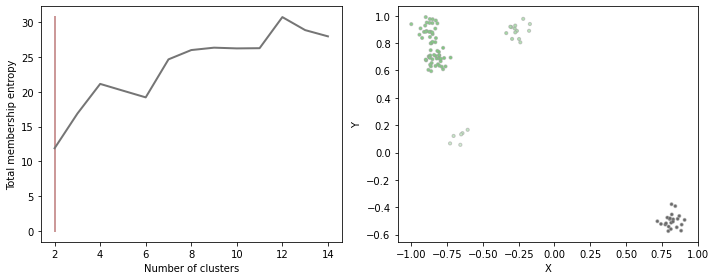

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot([optimal_nclusters, optimal_nclusters], [0, np.max(total_entropies)], color=(0.8,0.6,0.6), linewidth=2)
axes[0].plot(n_clusters_trials, total_entropies, color=(0.46,0.46,0.46), linewidth=2)
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Total membership entropy')

color_seq = list()
for j in range(0, dataset.shape[0]):
    color_seq.append(make_rgb_transparent(edgecolors[representative_cluster[j]], 1-Sx[j]))
axes[1].scatter(dataset[:,0], dataset[:,1], marker='.', s=40, edgecolors=(0.6,0.6,0.6,0.5), c=color_seq)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

plt.tight_layout()
plt.show()

**Cluster quality**

In [100]:
Si = list()
for clust in set(representative_cluster):
    probs = p[np.argmax(p, 1)==clust, :]
    entropy = -np.sum(probs*np.log(probs), 1) / np.log(probs.shape[1])
    Si.append(np.mean(entropy))
    
_=[print("Mean membership entropy across cluster {0} = {1}".format(i, np.round(Si[i], 3))) for i in range(0, len(Si))]

Mean membership entropy across cluster 0 = 0.149
Mean membership entropy across cluster 1 = 0.012


In [96]:
np.mean(Si)
print(representative_cluster)


[2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 2 2 2 2 2 2]


Initialize fcmeans with different seeds the do statistics would probably help

As suggested in Prado 2020, we can calculate cluster quality and rerun cluster for the subsuf of clusters of lower quality

Important observation:

In the case of linear relationships, PCA can be used (taking the dataset as input) and a way to discover the number of clusters, which will be the number of relevant principal components

In this construction, by construction the features in each cluster are uncorrelated with the features in the other clusters, which simplifies things a lot

**References:**

{% bibliography --cited %}